# assignment 1

> Joshua Schmidt

_I pledge my honor that I have abided by the Stevens Honor System_

Below is the cleaning section. In this function, the input data is split into paragraphs and labeled by the corresponding author. The string is converted to lowercase characters, and whitespace is trimmed, in order to make the text more uniform. The data itself is outputted as a dataframe.

In [2]:
from clean import clean
clean_data, label_list = clean()

2020-09-21 18:33:49.602 | INFO     | utils:get_glob:17 - getting files using glob
2020-09-21 18:33:49.609 | INFO     | clean:clean:40 - processing austen
2020-09-21 18:33:49.610 | INFO     | clean:clean:66 - title: the complete project gutenberg works of jane austen
2020-09-21 18:33:49.612 | INFO     | clean:clean:69 - author: jane austen
2020-09-21 18:33:49.664 | INFO     | clean:clean:86 - number of paragraphs in class "Jane Austen": 2497
2020-09-21 18:33:49.667 | INFO     | clean:clean:40 - processing dostoyevsky
2020-09-21 18:33:49.668 | INFO     | clean:clean:66 - title: the brothers karamazov
2020-09-21 18:33:49.669 | INFO     | clean:clean:69 - author: fyodor dostoyevsky
2020-09-21 18:33:49.721 | INFO     | clean:clean:86 - number of paragraphs in class "Fyodor Dostoyevsky": 5840
2020-09-21 18:33:49.726 | INFO     | clean:clean:40 - processing doyle
2020-09-21 18:33:49.728 | INFO     | clean:clean:66 - title: the adventures of sherlock holmes
2020-09-21 18:33:49.729 | INFO     |

In this next section, the dataframe and list of labels is inputted as parameters to the training function. The training function trains both the linear regression and multi-layer perceptron, and evaluates the performance of both models at the end.

2020-09-21 19:02:33.167 | INFO     | train:train:44 - start test train split
2020-09-21 19:02:35.805 | INFO     | train:train:95 - test train split complete
2020-09-21 19:02:35.805 | INFO     | train:train:98 - start text transform
2020-09-21 19:02:36.527 | INFO     | train:train:101 - text transformed
2020-09-21 19:02:36.528 | INFO     | train:train:104 - logistic regression:
2020-09-21 19:02:36.529 | INFO     | train:train:105 - start logistic regression fit
2020-09-21 19:02:39.251 | INFO     | train:train:107 - done with logistic regression train fit
2020-09-21 19:02:39.255 | INFO     | train:train:108 - logistic regression testing score: 0.9103139013452914
2020-09-21 19:02:39.255 | INFO     | train:train:111 - multi layer perceptron:
2020-09-21 19:02:39.256 | INFO     | train:train:112 - start mlp classifier fit
2020-09-21 19:02:39.258 | INFO     | train:train:115 - epoch 1
2020-09-21 19:02:40.154 | INFO     | train:train:115 - epoch 2
2020-09-21 19:02:41.009 | INFO     | train:tra

2020-09-21 19:03:57.154 | INFO     | train:train:126 - mlp testing score: 1.0
2020-09-21 19:03:57.157 | INFO     | train:train:95 - test train split complete
2020-09-21 19:03:57.160 | INFO     | train:train:98 - start text transform
2020-09-21 19:03:57.861 | INFO     | train:train:101 - text transformed
2020-09-21 19:03:57.861 | INFO     | train:train:104 - logistic regression:
2020-09-21 19:03:57.862 | INFO     | train:train:105 - start logistic regression fit
2020-09-21 19:04:01.644 | INFO     | train:train:107 - done with logistic regression train fit
2020-09-21 19:04:01.647 | INFO     | train:train:108 - logistic regression testing score: 0.9205921938088829
2020-09-21 19:04:01.648 | INFO     | train:train:111 - multi layer perceptron:
2020-09-21 19:04:01.648 | INFO     | train:train:112 - start mlp classifier fit
2020-09-21 19:04:01.649 | INFO     | train:train:115 - epoch 1
2020-09-21 19:04:02.390 | INFO     | train:train:115 - epoch 2
2020-09-21 19:04:03.260 | INFO     | train:tr

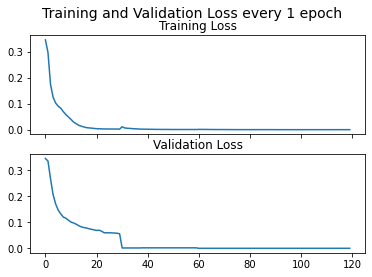

In [7]:
from train import train
train(clean_data, label_list)